In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd "/content/drive/MyDrive/Colab Notebooks/Transformer"

/content/drive/.shortcut-targets-by-id/17vBJAZeuDCte4t5jYXL1emXc1Rm4jOqV/Transformer


In [3]:
import sys
sys.path.append("/content/drive/MyDrive/Colab Notebooks/packages")
import slacknotice # オリジナルモジュール slacknotice.send("")

In [4]:
notebook_dir="/content/drive/MyDrive/Colab Notebooks/Transformer"

# ライブラリ読み込み

In [5]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.6
!pip install japanize_matplotlib

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-locale-perl libfcgi-perl
  libhtml-parser-perl libhtml-tagset-perl libhttp-date-perl
  libhttp-message-perl libio-html-perl libio-string

In [6]:
import numpy as np
import os
import time
import MeCab

import preprocess_utils_law
import model
import weight_utils

import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

2.8.0


# 日英法令対訳コーパス ダウンロード

In [ ]:
!wget http://www.phontron.com/jaen-law/jaen-law.tar.gz

In [ ]:
!tar -xzf jaen-law.tar.gz # tar.gzの解凍

# データ読み込み

In [7]:
dataset = preprocess_utils_law.CreateData(
    corpus_path_source = './jaen-law/txt/law-corpus.ja',
    corpus_path_target = './jaen-law/txt/law-corpus.en',
    do_shuffle=True,
    seed_value=123,
    split_percent=0.95 # 学習データの割合
)

train_source, train_target, test_source, test_target= dataset.split_data()

print('**** Amount of data ****')
print('train_source： ', len(train_source))
print('train_target： ', len(train_target))
print('test_source： ', len(test_source))
print('test_target： ', len(test_target))
print('\n')
print('**** Train data example ****')
print('Source Example： ', train_source[0])
print('Target Example： ', train_target[0])
print('\n')
print('**** Test data example ****')
print('Source Example： ', test_source[0])
print('Target Example： ', test_target[0])

**** Amount of data ****
train_source：  249327
train_target：  249327
test_source：  13122
test_target：  13122


**** Train data example ****
Source Example：  第二十六条の四　前条第三項の認定を受けた事業主（以下「認定事業主」という。）は、当該認定に係る実施計画を変更しようとするときは、厚生労働大臣の認定を受けなければならない。

Target Example：  Article 26-4  (1) An employer who has received the accreditation set forth in paragraph (3) of the preceding Article (hereinafter referred to as an "accredited employer") shall, when intending to change the plan for providing training pertaining to said accreditation, receive accreditation thereof from the Minister of Health, Labour and Welfare.



**** Test data example ****
Source Example：  附　則　〔平成十九年三月三十一日法律第二十三号〕〔抄〕

Target Example：  Supplementary Provisions  [Act No. 23 of March 31, 2007]  [Extract]



# 前処理

In [8]:
BATCH_SIZE = 64 # バッチサイズ
MAX_LENGTH = 60 # シーケンスの長さ
USE_TPU = True # TPUを使うか
BUFFER_SIZE = 50000

In [9]:
train_dataset = preprocess_utils_law.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = train_source,
    target_data = train_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = False,
    train_dataset = None,
)

train_dataset.preprocess_data()

In [10]:
test_dataset = preprocess_utils_law.PreprocessData(
    mecab = MeCab.Tagger("-Ochasen"),
    source_data = test_source,
    target_data = test_target,
    max_length = MAX_LENGTH,
    batch_size = BATCH_SIZE,
    test_flag = True,
    train_dataset = train_dataset
)

test_dataset.preprocess_data()

# バッチ作成

In [11]:
if USE_TPU:
  tpu_grpc_url = "grpc://" + os.environ["COLAB_TPU_ADDR"]
  tpu_cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu_grpc_url)
  tf.config.experimental_connect_to_cluster(tpu_cluster_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_cluster_resolver)    
  strategy = tf.distribute.TPUStrategy(tpu_cluster_resolver)

trainset = tf.data.Dataset.from_tensor_slices((train_dataset.source_vector, train_dataset.target_vector))
trainset = trainset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

if USE_TPU:
  trainset = strategy.experimental_distribute_dataset(trainset)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.67.7.98:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.67.7.98:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [12]:
if USE_TPU:
  PREDICT_BATCH_SIZE = 8
  testset = tf.data.Dataset.from_tensor_slices((test_dataset.source_vector, test_dataset.target_vector))
  testset = testset.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))).shuffle(buffer_size=50000).batch(PREDICT_BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  testset = testset.take(1)
  testset = strategy.experimental_distribute_dataset(testset)

# モデル定義

In [13]:
num_layers=4 # レイヤー数
d_model=64 # 中間層の次元数
num_heads=4 # Multi Head Attentionのヘッド数
dff=2048 # Feed Forward Networkの次元数
dropout_rate = 0.1 # ドロップアウト率

source_vocab_size = max(train_dataset.source_token.values()) + 1 # source文の語彙数
target_vocab_size = max(train_dataset.target_token.values()) + 1 # target文の語彙数

In [14]:
# 重み初期化
def initialize_weight(checkpoint_path, optimizer, transformer, max_length, batch_size, use_tpu=False):

  if os.path.exists(checkpoint_path+'.pkl'):
    if use_tpu:
      number_of_tpu_cores = tpu_cluster_resolver.num_accelerators()['TPU']
      initialize_source, initialize_target = [[1]*max_length]*number_of_tpu_cores, [[1]*max_length]*number_of_tpu_cores
      initialize_set = tf.data.Dataset.from_tensor_slices((initialize_source, initialize_target))
      initialize_set = initialize_set.map(lambda source, target: (tf.cast(source, tf.int64), tf.cast(target, tf.int64))
          ).shuffle(buffer_size=BUFFER_SIZE).batch(batch_size).prefetch(
              buffer_size=tf.data.experimental.AUTOTUNE
          )
      initialize_set = strategy.experimental_distribute_dataset(initialize_set)

      for inp, tar in initialize_set:
          distributed_train_step(inp, tar)

    else:
      initialize_set = tf.ones([batch_size, max_length], tf.int64)
      train_step(initialize_set, initialize_set)
    
    try:
      weight_utils.load_weights_from_pickle(checkpoint_path, optimizer, transformer)
    except:
      print('Failed to load checkpoints.')

  else:
    print('No available checkpoints.')

# 予測

In [15]:
%%time
with strategy.scope():
  # Transformer
  transformer = model.Transformer(num_layers, d_model, num_heads, dff,
                            source_vocab_size, target_vocab_size, 
                            pe_input=source_vocab_size, 
                            pe_target=target_vocab_size,
                            rate=dropout_rate)

  # Learning Rate
  learning_rate = model.CustomSchedule(d_model)

  # Optimizer
  optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                      epsilon=1e-9)

  # Loss
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

  # Loss Function
  def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

  # Metrics
  train_loss = tf.keras.metrics.Mean(name='train_loss')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

  # Checkpoint
  #checkpoint_path = "/content/drive/My Drive/Transformer-master/checkpoints/tpu/model"
  checkpoint_path = notebook_dir+"/checkpoints/tpu/model"

  def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    
    enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar_inp)
    
    with tf.GradientTape() as tape:
      predictions, _ = transformer(inp, tar_inp, 
                                  True, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    
    train_loss(loss)
    train_accuracy(tar_real, predictions)

  @tf.function
  def distributed_train_step(X, y):
    per_replica_losses = strategy.run(train_step, args=(X, y))
    return strategy.reduce(tf.distribute.ReduceOp.MEAN, per_replica_losses, axis=None)

  def test_step(inp, tar):
      enc_padding_mask, combined_mask, dec_padding_mask = model.create_masks(inp, tar)
      
      predictions, attention_weights = transformer(inp, tar, 
                                  False, 
                                  enc_padding_mask, 
                                  combined_mask, 
                                  dec_padding_mask)
      
      predicted_id = tf.cast(tf.argmax(predictions[: ,-1:, :], axis=-1), tf.int64)
      return inp, tf.concat([tar, predicted_id], axis=-1), attention_weights

  @tf.function
  def distributed_test_step(X, y):
        return strategy.experimental_local_results(strategy.run(test_step, args=(X, y)))


  # Initialize Weight
  initialize_weight(checkpoint_path, optimizer, transformer, MAX_LENGTH, PREDICT_BATCH_SIZE, use_tpu=USE_TPU)

  for inp, tar in testset:
    for i in range(MAX_LENGTH):
        inp, tar, attn = distributed_test_step(inp, tar)[0]

Cause: Unable to locate the source code of <function distributed_train_step at 0x7fa67c5277a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function distributed_train_step at 0x7fa67c5277a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function distributed_train_step at 0x7fa67c5277a0>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function train_step at 0x7fa67c527710>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the functi

Cause: Unable to locate the source code of <function train_step at 0x7fa67c527710>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function train_step at 0x7fa67c527710>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Load checkpoints successfully.
Cause: Unable to locate the source code of <function distributed_test_step at 0x7fa67c527950>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence thi

Cause: Unable to locate the source code of <function distributed_test_step at 0x7fa67c527950>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function distributed_test_step at 0x7fa67c527950>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: Unable to locate the source code of <function test_step at 0x7fa67c527830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function

Cause: Unable to locate the source code of <function test_step at 0x7fa67c527830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function test_step at 0x7fa67c527830>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


CPU times: user 2min 28s, sys: 6.85 s, total: 2min 35s
Wall time: 5min 3s


In [16]:
def plot_attention_weight(sentence, attention, result):
  fig = plt.figure(figsize=(16, 8))

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    #ax.matshow(attention[head][:-1, :], cmap='viridis')
    #ax.matshow(attention[head], cmap='viridis')
    ax.matshow(attention[head][:-1], cmap='viridis')

    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(result.shape[0]))
    
    ax.set_ylim(result.shape[0]-1.5, -0.5)
        
    tmp_list = []
    for i in sentence:
      try:
        tmp_list.append(train_dataset.source_index[i.numpy()])
      except:
        pass

    ax.set_xticklabels(tmp_list, fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([train_dataset.target_index[i.numpy()] for i in result 
                        if i < max(train_dataset.target_token.values()) - 1], 
                        fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

Input: （ 不当 労働 行為 ）
Output: (UnfairLaborPractices)


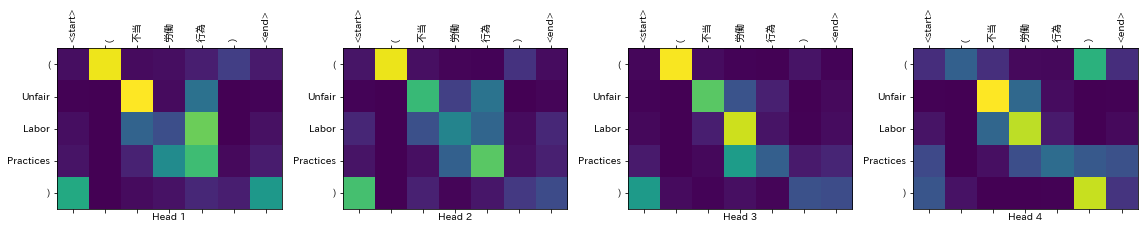

In [53]:
for i, (s, t, a) in enumerate(zip(inp, tar, attn['decoder_layer4_block2'])):
  sentence = tf.squeeze(s)[:tf.argmax(tf.squeeze(s)).numpy()+1]
  attention = a[:,:, :sentence.shape[0]]
  result = tf.squeeze(t)[:tf.argmax(tf.squeeze(t)).numpy()+1][1:]
  print("Input:", ' '.join([train_dataset.source_index[i.numpy()] for i in sentence][1:-1]))
  print("Output:", ''.join([train_dataset.target_index[i.numpy()] for i in result][:-1]))
  plot_attention_weight(sentence, attention, result)

In [ ]:
"""
for i, (s, t, a) in enumerate(zip(inp.values, tar.values, attn['decoder_layer4_block2'].values)):
  sentence = tf.squeeze(s)[:tf.argmax(tf.squeeze(s)).numpy()+1]
  attention = a[0,:, :, :sentence.shape[0]]
  result = tf.squeeze(t)[:tf.argmax(tf.squeeze(t)).numpy()+1][1:]
  print("Input:", ' '.join([train_dataset.source_index[i.numpy()] for i in sentence][1:-1]))
  print("Output:", ''.join([train_dataset.target_index[i.numpy()] for i in result][:-1]))
  plot_attention_weight(sentence, attention, result)
"""

In [ ]:
list(inp.numpy()[0])

In [ ]:
attn['decoder_layer4_block2'].numpy()

In [ ]:
list(zip(inp.numpy(), tar.numpy(), attn['decoder_layer4_block2'].numpy()))

In [21]:
inp.values

AttributeError: ignored

In [24]:
sentence

<tf.Tensor: shape=(7,), dtype=int64, numpy=array([18421,    18,   903,    39,   114,    25, 18422])>

In [25]:
sentence.shape[0]

7

In [ ]:
a[0,:, :sentence.shape[0]]

In [23]:
attention.shape

TensorShape([4, 119, 7])

In [29]:
result.numpy()

array([    5,  7688,  2710,  6022,     7, 29727])

In [30]:
len(attention)

4

In [31]:
attention.shape

TensorShape([4, 119, 7])

In [47]:
sentence.shape

TensorShape([7])

In [33]:
result.shape

TensorShape([6])

In [34]:
inp.numpy()

array([[18421,    18,   903,    39,   114,    25, 18422,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0]])

In [ ]:
list(enumerate(zip(inp.numpy(), tar.numpy(), attn['decoder_layer4_block2'].numpy())))

In [36]:
len(list(enumerate(zip(inp.numpy(), tar.numpy(), attn['decoder_layer4_block2'].numpy())))[0][0])

TypeError: ignored

In [41]:
a.shape

TensorShape([4, 119, 60])

In [ ]:
 a[0,:, :sentence.shape[0]]

In [ ]:
attention[0]

In [39]:
attention.shape

TensorShape([4, 119, 7])

In [51]:
attn['decoder_layer4_block2'].numpy()[0,:, :sentence.shape[0]].shape

(4, 7, 60)